In [1]:
# Exploracion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Configuraciones
import joblib

import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().resolve()
while PROJECT_DIR != PROJECT_DIR.parent and not (PROJECT_DIR / "src").exists():
    PROJECT_DIR = PROJECT_DIR.parent
sys.path.insert(0, str(PROJECT_DIR))
from src.config import SEED, TEST_SIZE, VAL_SIZE
from src.utils.seeds import set_seeds
from src.paths import DATA_RAW, DATA_PROCESSED

set_seeds(SEED)

reviews = pd.read_csv(DATA_RAW / "olist_order_reviews_dataset.csv").copy()

In [2]:
# EDA mínimo y limpieza básica
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [3]:
#Columnas innecesarias
reviews.drop(['order_id', 'review_creation_date', 'review_answer_timestamp'],axis=1, inplace= True, errors='ignore')

# % missing en texto
(reviews[["review_comment_title", "review_comment_message"]].isna().mean() * 100).sort_values(ascending=False)

#si no hay texto, no sirve
df = reviews.copy()
df["text"] = (df["review_comment_title"].fillna("") + " " + df["review_comment_message"].fillna("")).str.strip()
df = df[df["text"].str.len() > 0].copy()
df.shape

(42687, 5)

In [4]:
# Definir target (negativo vs positivo)
# (0=positivo, 1=negativo)

df = df[df["review_score"].isin([1,2,4,5])].copy()
df["label"] = (df["review_score"] <= 2).astype(int)
df["label"].value_counts(normalize=True)

label
0    0.71842
1    0.28158
Name: proportion, dtype: float64

In [5]:
# Modelado para entrenamiento
X = df['text']
y = df['label']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=TEST_SIZE, random_state=SEED, stratify=y_trainval
)

len(X_train), len(X_val), len(X_test)

(24988, 6247, 7809)

In [6]:
# Pipeline NLP (TF-IDF) + modelos a comparar
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words= None,
    min_df=5,
    ngram_range=(1,2),
    max_features=3000
)

models = {
    "Dummy": DummyClassifier(strategy="most_frequent", random_state=SEED),
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED),
    "LinearSVC": LinearSVC(class_weight="balanced", random_state=SEED),
    "MultinomialNB": MultinomialNB(),
}

In [7]:
# Entrenamiento y comparación en VALIDACIÓN
results = []
fitted = {}

for name, clf in models.items():
    pipe = Pipeline(
        [
        ("tfidf", tfidf),
        ("clf", clf),
        ]
    )
 
    pipe.fit(X_train,y_train)
    pred_val = pipe.predict(X_val)
    f1 = f1_score(y_val, pred_val, average="macro")
    results.append((name, f1))
    fitted[name] = pipe

res_df = pd.DataFrame(results, columns=["model", "F1_macro_val"]).sort_values("F1_macro_val", ascending=False)
res_df

,model,F1_macro_val
1,LogReg,0.923443
2,LinearSVC,0.921227
3,MultinomialNB,0.916001
0,Dummy,0.418072


In [8]:
best_name = res_df.iloc[0]["model"]
best_pipe = fitted[best_name]

pred_test = best_pipe.predict(X_test)

print("Best model:", best_name)
print("F1 macro (test):", f1_score(y_test, pred_test, average="macro"))
print(classification_report(y_test, pred_test, digits=3))


Best model: LogReg
F1 macro (test): 0.9204660784136212
              precision    recall  f1-score   support

           0      0.978     0.927     0.952      5610
           1      0.837     0.948     0.889      2199

    accuracy                          0.933      7809
   macro avg      0.907     0.938     0.920      7809
weighted avg      0.938     0.933     0.934      7809



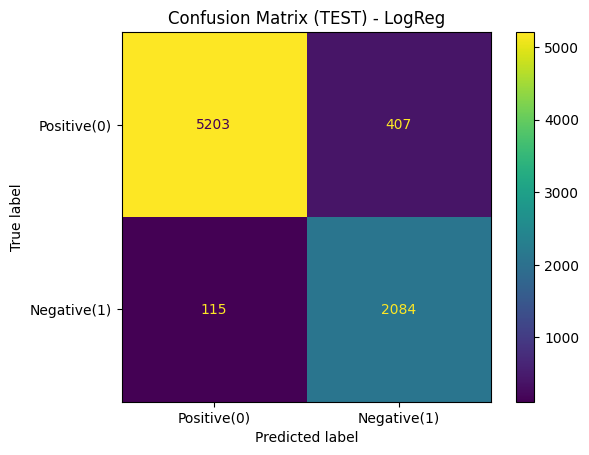

In [9]:
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive(0)", "Negative(1)"])
disp.plot()
plt.title(f"Confusion Matrix (TEST) - {best_name}")
plt.show()

In [10]:
model_path = "sentiment_pipeline.joblib"
joblib.dump(best_pipe, model_path)
model_path


'sentiment_pipeline.joblib'

In [16]:
# ejemplo inferencia
examples = pd.Series([
    "produto chegou quebrado e atrasado, muito ruim",
    "chegou antes do prazo, ótimo vendedor, recomendo",
    "não recebi o produto, péssimo atendimento",
    "ta bom",
    "Chegou com defeito e não funciona como descrito",
    "Produto muito bom! Funciona perfeitamente e a qualidade superou minhas expectativas. Entrega rápida e bem embalado.",
    "Excelente custo-benefício. Fácil de usar, material resistente e exatamente como descrito no anúncio. Recomendo!"
])

predictions = best_pipe.predict(examples)

#Mapear las etiquetas
labels = pd.Series(predictions).map({
    0: "Positiva",
    1: "Negativa"
})

#To tadaframe
results_df = pd.DataFrame({
    "Review": examples,
    "Sentimiento": labels
})

display(results_df)

,Review,Sentimiento
0,"produto chegou quebrado e atrasado, muito ruim",Negativa
1,"chegou antes do prazo, ótimo vendedor, recomendo",Positiva
2,"não recebi o produto, péssimo atendimento",Negativa
3,ta bom,Positiva
4,Chegou com defeito e não funciona como descrito,Negativa
5,Produto muito bom! Funciona perfeitamente e a ...,Positiva
6,"Excelente custo-benefício. Fácil de usar, mate...",Positiva
